In [40]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

from torchvision.models import resnet50, ResNet50_Weights

In [7]:
# Import ResNet50
model = resnet50(weights=ResNet50_Weights.DEFAULT)

In [33]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [10]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    # transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # [0,1]->[-1,1]
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # [0,1]->[-1,1]
])

In [23]:
train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)

trainloader = torch.utils.data.DataLoader(train, batch_size=16, shuffle=True, num_workers=2)

test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

testloader = torch.utils.data.DataLoader(test, batch_size=16,shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


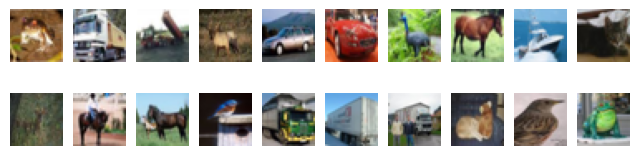

In [30]:
# show some images
plt.figure(figsize=(8, 2))
for i in range(20):
    plt.subplot(2, 10, i + 1)
    image, _ = trainloader.dataset.__getitem__(i)
    image_display = image * 0.5 + 0.5
    plt.imshow(image_display.permute(1, 2, 0).numpy())
    plt.axis("off")

In [47]:
import torch_directml

# 1. Apple Silicon (Mac M1/M2/M3)
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    DEVICE = torch.device("mps")
    print("Utilisation de : Apple Silicon (MPS)")

# 2. NVIDIA GPU (CUDA)
elif torch.cuda.is_available():
    DEVICE = torch.device("cuda:0")
    print("Utilisation de : NVIDIA GPU (CUDA)")

# 3. AMD GPU / Windows-WSL (DirectML)
elif torch_directml.is_available():
    DEVICE = torch_directml.device()
    print("Utilisation de : AMD GPU (DirectML)")

# 4. Fallback to CPU
else:
    DEVICE = torch.device("cpu")
    print("Utilisation de : CPU")

print(DEVICE)

Utilisation de : AMD GPU (DirectML)
privateuseone:0


In [ ]:
class myBCELoss(nn.Module):
    def __init__(self):
        super(myBCELoss, self).__init__()

    def forward(self, logits, targets):
        # 1. On transforme les logits en probabilités via Sigmoid
        # sigmoid(x) = 1 / (1 + exp(-x))
        probs = torch.sigmoid(logits)
        
        # 2. On applique la formule de la BCE
        # On ajoute un petit 'eps' (1e-7) pour éviter log(0) qui donne -inf
        eps = 1e-7
        loss = -(targets * torch.log(probs + eps) + (1 - targets) * torch.log(1 - probs + eps))
        
        # 3. On renvoie la moyenne
        return loss.mean()

In [34]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, patience=5)

In [44]:
EPOCHS = 200
for epoch in range(EPOCHS):
    losses = []
    running_loss = 0
    for i, inp in enumerate(trainloader):
        inputs, labels = inp
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
    
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if i%100 == 0 and i > 0:
            print(f'Loss [{epoch+1}, {i}](epoch, minibatch): ', running_loss / 100)
            running_loss = 0.0

    avg_loss = sum(losses)/len(losses)
    scheduler.step(avg_loss)
            
print('Training Done')

RuntimeError: tensor.device().type() == at::DeviceType::PrivateUse1 INTERNAL ASSERT FAILED at "/__w/1/s/pytorch-directml-plugin/torch_directml/csrc/dml/DMLTensor.cpp":30, please report a bug to PyTorch. unbox expects Dml at::Tensor as inputs